# TorchIO: a tutorial

In this tutorial, we will train a [3D U-Net](https://link.springer.com/chapter/10.1007/978-3-319-46723-8_49) to perform brain segmentation from T1-weighted MRI using the [Information eXtraction from Images (IXI) dataset](https://brain-development.org/ixi-dataset/), a publicly available dataset of almost 600 subjects.

## Setup

In [1]:
# Config
seed = 42  # for reproducibility
training_split_ratio = 0.9  # use 90% of samples for training, 10% for testing
num_epochs = 5

# If the following values are False, the models will be downloaded and not computed
compute_histograms = False
train_whole_images = False 
train_patches = False

Install some PyPI packages:

In [2]:
!pip install --quiet --upgrade pip
!pip install --quiet --upgrade niwidgets
!pip install --quiet --upgrade highresnet
!pip install --quiet --upgrade unet
!pip install --quiet --upgrade torchio
!apt-get -qq install tree

     |████████████████████████████████| 1.5MB 9.1MB/s 
     |████████████████████████████████| 12.5 MB 45 kB/s 
     |████████████████████████████████| 2.9 MB 74.5 MB/s 
     |████████████████████████████████| 1.1 MB 76.7 MB/s 
     |████████████████████████████████| 3.3 MB 67.6 MB/s 
     |████████████████████████████████| 2.3 MB 65.6 MB/s 
     |████████████████████████████████| 17.4 MB 119 kB/s 
     |████████████████████████████████| 3.3 MB 61.9 MB/s 
     |████████████████████████████████| 259 kB 80.6 MB/s 
     |████████████████████████████████| 5.4 MB 15.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.4.6 requires numpy>=1.17, but you have numpy 1.16.6 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have img

Import modules:

In [3]:
import copy
import enum
import random; random.seed(seed)
import warnings
import tempfile
import subprocess
import multiprocessing
from pathlib import Path

import torch
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
torch.manual_seed(seed)

import torchio as tio
from torchio import AFFINE, DATA

import numpy as np
import nibabel as nib
from unet import UNet
from scipy import stats
import SimpleITK as sitk
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm

print('TorchIO version:', tio.__version__)

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits

TorchIO version: 0.18.1


Define some visualization functions:

In [4]:
#@title (Helper functions, double-click here to expand)
def show_nifti(image_path_or_image, colormap='gray'):
    try:
        from niwidgets import NiftiWidget
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            widget = NiftiWidget(image_path_or_image)
            widget.nifti_plotter(colormap=colormap)
    except Exception:
        if isinstance(image_path_or_image, nib.AnalyzeImage):
            nii = image_path_or_image
        else:
            image_path = image_path_or_image
            nii = nib.load(str(image_path))
        k = int(nii.shape[-1] / 2)
        plt.imshow(nii.dataobj[..., k], cmap=colormap)

def show_subject(subject, image_name, label_name=None):
    if label_name is not None:
        subject = copy.deepcopy(subject)
        affine = subject[label_name].affine
        label_image = subject[label_name].as_sitk()
        label_image = sitk.Cast(label_image, sitk.sitkUInt8)
        border = sitk.BinaryContour(label_image)
        border_array, _ = tio.utils.sitk_to_nib(border)
        border_tensor = torch.from_numpy(border_array)[0]
        image_tensor = subject[image_name].data[0]
        image_tensor[border_tensor > 0.5] = image_tensor.max()
    with tempfile.NamedTemporaryFile(suffix='.nii') as f:
        subject[image_name].save(f.name)
        show_nifti(f.name)

def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

## Data

### Dataset

I downloaded the [IXI](https://brain-development.org/ixi-dataset/) dataset, segmented all brains using [ROBEX](https://ieeexplore.ieee.org/document/5742706), affine-registered everything to an MNI template with [NiftyReg](https://github.com/KCL-BMEIS/niftyreg), resampled everything into a space with a very large voxel spacing and funny orientation with [ITK](https://itk.org/) and uploaded a zip file to Dropbox.
It will be our medical image MNIST.

In [5]:
# Dataset
dataset_url = 'https://www.dropbox.com/s/ogxjwjxdv5mieah/ixi_tiny.zip?dl=0'
dataset_path = 'ixi_tiny.zip'
dataset_dir_name = 'ixi_tiny'
dataset_dir = Path(dataset_dir_name)
histogram_landmarks_path = 'landmarks.npy'

In [6]:
if not dataset_dir.is_dir():
    !curl --silent --output {dataset_path} --location {dataset_url} 
    !unzip -qq {dataset_path}
!tree -d {dataset_dir_name}

ixi_tiny
├── image
└── label

2 directories


### [`SubjectsDataset`](https://torchio.readthedocs.io/data/dataset.html)

This is one of the most important classes in the library. It inherits from `torch.utils.data.Dataset`. It receives as input a list of [`torchio.Subject`](https://torchio.readthedocs.io/data/subject.html#subject) instances and an optional [`torchio.transforms.Transform`](https://torchio.readthedocs.io/transforms/transforms.html#torchio.transforms.Transform). 

The inputs to the subject class are instances of `torchio.Image`, such as [`torchio.ScalarImage`](https://torchio.readthedocs.io/data/image.html#scalarimage) or [`torchio.LabelMap`](https://torchio.readthedocs.io/data/image.html#labelmap). The image class will be used by the transforms to decide whether or not to perform the operation. For example, spatial transforms must apply to both, but intensity transforms must apply to scalar images only.

In [7]:
images_dir = dataset_dir / 'image'
labels_dir = dataset_dir / 'label'
image_paths = sorted(images_dir.glob('*.nii.gz'))
label_paths = sorted(labels_dir.glob('*.nii.gz'))
assert len(image_paths) == len(label_paths)

subjects = []
for (image_path, label_path) in zip(image_paths, label_paths):
    subject = tio.Subject(
        mri=tio.ScalarImage(image_path),
        brain=tio.LabelMap(label_path),
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 566 subjects


Let's take a look into the sample returned by the dataset:

Subject(Keys: ('mri', 'brain'); images: 2)
ScalarImage(shape: (1, 83, 44, 55); spacing: (2.18, 4.13, 3.95); orientation: SRA+; memory: 784.6 KiB; type: intensity)


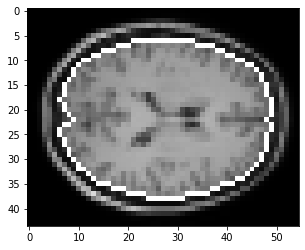

In [8]:
one_subject = dataset[0]
print(one_subject)
print(one_subject.mri)
show_subject(tio.ToCanonical()(one_subject), 'mri', label_name='brain')

## [Transforms](https://torchio.readthedocs.io/transforms/transforms.html#transforms)

For a full tutorial on TorchIO transforms, check out our [Data preprocessing and augmentation using TorchIO](https://github.com/fepegar/torchio/blob/master/examples/README.md) tutorial.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/fepegar/torchio/blob/master/examples/README.md)

#### Normalization

We will use the [`HistogramStandardization`]() and the [`ZNormalization`]() transforms to normalize our images intensity.

The images have been acquired by different MRI scanners at different hospitals. We will apply some normalization techniques so that intensities are similarly distributed and within similar ranges.

Training the histogram is typically quite fast. It takes long here because of the fancy plotting.

In [9]:
paths = image_paths

if compute_histograms:
    fig, ax = plt.subplots(dpi=100)
    for path in tqdm(paths):
        tensor = tio.ScalarImage(path).data
        if 'HH' in path.name: color = 'red'
        elif 'Guys' in path.name: color = 'green'
        elif 'IOP' in path.name: color = 'blue'
        plot_histogram(ax, tensor, color=color)
    ax.set_xlim(-100, 2000)
    ax.set_ylim(0, 0.004);
    ax.set_title('Original histograms of all samples')
    ax.set_xlabel('Intensity')
    ax.grid()
    graph = None
else:
    graph = display.Image(url='https://www.dropbox.com/s/daqsg3udk61v65i/hist_original.png?dl=1')
graph

##### Normalization

We will use 

In [10]:
landmarks = tio.HistogramStandardization.train(
    image_paths,
    output_path=histogram_landmarks_path,
)
np.set_printoptions(suppress=True, precision=3)
print('\nTrained landmarks:', landmarks)

100%|██████████| 566/566 [00:05<00:00, 100.76it/s]


Trained landmarks: [  0.      0.002   0.108   0.227   0.467   2.014  15.205  34.297  49.664
  55.569  61.178  74.005 100.   ]


In [11]:
landmarks_dict = {'mri': landmarks}
histogram_transform = tio.HistogramStandardization(landmarks_dict)

if compute_histograms:
    fig, ax = plt.subplots(dpi=100)
    for i ,sample in enumerate(tqdm(dataset)):
        standard = histogram_transform(sample)
        tensor = standard.mri.data
        path = str(sample.mri.path)
        if 'HH' in path: color = 'red'
        elif 'Guys' in path: color = 'green'
        elif 'IOP' in path: color = 'blue'
        plot_histogram(ax, tensor, color=color)
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 0.02)
    ax.set_title('Intensity values of all samples after histogram standardization')
    ax.set_xlabel('Intensity')
    ax.grid()
    graph = None
else:
    graph = display.Image(url='https://www.dropbox.com/s/dqqaf78c86mrsgn/hist_standard.png?dl=1')
graph

##### Z-normalization

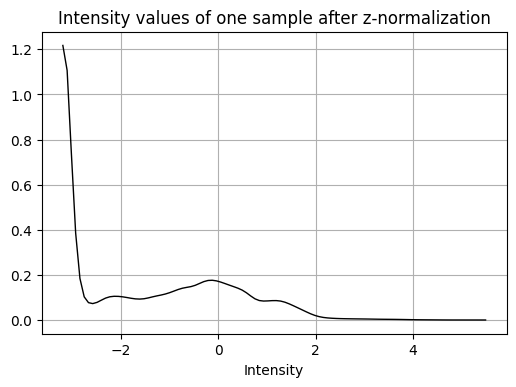

In [12]:
znorm_transform = tio.ZNormalization(masking_method=tio.ZNormalization.mean)

sample = dataset[0]
transform = tio.Compose([histogram_transform, znorm_transform])
znormed = transform(sample)

fig, ax = plt.subplots(dpi=100)
plot_histogram(ax, znormed.mri.data, label='Z-normed', alpha=1)
ax.set_title('Intensity values of one sample after z-normalization')
ax.set_xlabel('Intensity')
ax.grid()

## Training a network



In [13]:
training_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.RandomMotion(p=0.2),
    tio.HistogramStandardization({'mri': landmarks}),
    tio.RandomBiasField(p=0.3),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomNoise(p=0.5),
    tio.RandomFlip(axes=(0,)),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    }),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.HistogramStandardization({'mri': landmarks}),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
])

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)

training_subjects = subjects[:num_training_subjects]
validation_subjects = subjects[num_training_subjects:]

training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 509 subjects
Validation set: 57 subjects


### Deep learning stuff

In [14]:
#@title (Deep learning functions, double-click here to expand)
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def prepare_batch(batch, device):
    inputs = batch['mri'][DATA].to(device)
    foreground = batch['brain'][DATA].to(device)
    background = 1 - foreground
    targets = torch.cat((background, foreground), dim=CHANNELS_DIMENSION)
    return inputs, targets

def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def forward(model, inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        logits = model(inputs)
    return logits

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = forward(model, inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer)
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer)
        run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer)
        torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth')

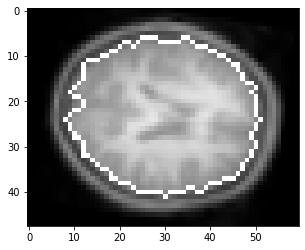

In [15]:
training_instance = training_set[42]  # transform is applied in SubjectsDataset
show_subject(training_instance, 'mri', label_name='brain')

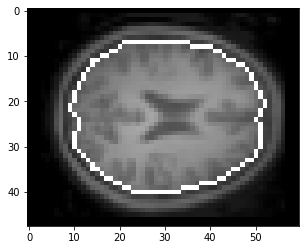

In [16]:
validation_instance = validation_set[42]
show_subject(validation_instance, 'mri', label_name='brain')

### Whole images

In [17]:
training_batch_size = 16
validation_batch_size = 2 * training_batch_size

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=multiprocessing.cpu_count(),
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=multiprocessing.cpu_count(),
)

Visualize axial slices of one batch

In [18]:
one_batch = next(iter(training_loader))

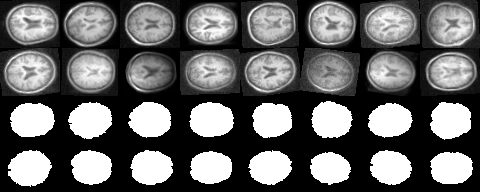

In [19]:
k = 24
batch_mri = one_batch['mri'][DATA][..., k]
batch_label = one_batch['brain'][DATA][..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = 'batch_whole_images.png'
save_image(slices, image_path, nrow=training_batch_size//2, normalize=True, scale_each=True, padding=0)
display.Image(image_path)

Train

In [20]:
model, optimizer = get_model_and_optimizer(device)

if train_whole_images:
    weights_stem = 'whole_images'
    train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)
else:
    weights_path = 'whole_image_state_dict.pth'
    weights_url = 'https://github.com/fepegar/torchio-data/raw/master/models/whole_images_epoch_5.pth'
    !curl --location --silent --output {weights_path} {weights_url}
    model.load_state_dict(torch.load(weights_path))

Inference

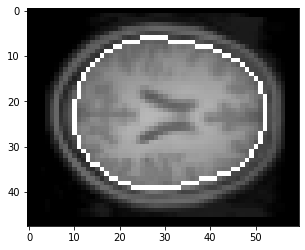

In [21]:
batch = next(iter(validation_loader))
model.eval()
inputs, targets = prepare_batch(batch, device)
with torch.no_grad():
    logits = forward(model, inputs)
labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True)
foreground = labels[0].cpu().numpy().astype(np.uint8)
affine = batch['mri'][AFFINE][0].numpy()
label_image = tio.utils.nib_to_sitk(foreground, affine)
border = sitk.BinaryContour(label_image)
border_array, _ = tio.utils.sitk_to_nib(border)
image_array = inputs[0, 0].cpu().numpy()
image_array[border_array[0] > 0.5] = image_array.max()
nii = nib.Nifti1Image(image_array, affine)
show_nifti(nii)

### Patch-based

In [22]:
training_batch_size = 32
validation_batch_size = 2 * training_batch_size

patch_size = 24
samples_per_volume = 5
max_queue_length = 300

patches_training_set = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=tio.data.UniformSampler(patch_size),
    num_workers=multiprocessing.cpu_count(),
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = tio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=tio.data.UniformSampler(patch_size),
    num_workers=multiprocessing.cpu_count(),
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

Visualize axial slices of one batch

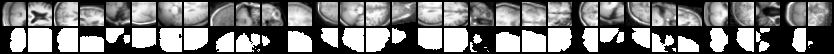

In [23]:
one_batch = next(iter(training_loader))
k = int(patch_size // 4)
batch_mri = one_batch['mri'][DATA][..., k]
batch_label = one_batch['brain'][DATA][..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = 'batch_patches.png'
save_image(slices, image_path, nrow=training_batch_size, normalize=True, scale_each=True)
display.Image(image_path)

Train

In [24]:
model, optimizer = get_model_and_optimizer(device)

if train_patches:
    weights_stem = 'patches'
    train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)
else:
    weights_path = 'patches_state_dict.pth'
    weights_url = 'https://github.com/fepegar/torchio-data/raw/master/models/patches_epoch_5.pth'
    !curl --location --silent --output {weights_path} {weights_url}
    model.load_state_dict(torch.load(weights_path))

Infer

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torchio/data/inference/aggregator.py:159: RuntimeWarning: Medical image frameworks such as ITK do not support int64. Casting to int32...
  warnings.warn(message, RuntimeWarning)


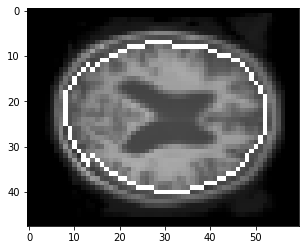

In [25]:
sample = random.choice(validation_set)
input_tensor = sample.mri.data[0]
patch_size = 48, 48, 48  # we can user larger patches for inference
patch_overlap = 4, 4, 4
grid_sampler = tio.inference.GridSampler(
    sample,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=validation_batch_size)
aggregator = tio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['mri'][DATA].to(device)
        locations = patches_batch[tio.LOCATION]
        logits = model(inputs)
        labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True)
        aggregator.add_batch(labels, locations)

foreground = aggregator.get_output_tensor()
affine = sample.mri.affine
label_image = tio.utils.nib_to_sitk(foreground, affine)
border = sitk.BinaryContour(label_image)
border_array, _ = tio.utils.sitk_to_nib(border)
input_tensor[border_array > 0.5] = input_tensor.max()
nii = nib.Nifti1Image(input_tensor.numpy(), affine)
show_nifti(nii)